In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install wandb

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from tensorflow.keras import Model
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import wandb
from wandb.keras import WandbCallback

In [ ]:

wandb.init(project='face recognition in expert mode')


In [5]:


config=wandb.config
config.learning_rate=0.001



In [6]:
#hyper parametersa

batch_size=32
epochs=30




In [7]:
width=height=224

In [8]:
dataset_path='/content/drive/MyDrive/faces'

In [9]:
idg=ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.1,
    rotation_range=20,
    shear_range=0.15,
    validation_split=0.2
)

train_data=idg.flow_from_directory(
    dataset_path,
    target_size=(width,height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)

val_data=idg.flow_from_directory(
    dataset_path,
    target_size=(width,height),
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation'
)



Found 1090 images belonging to 14 classes.
Found 268 images belonging to 14 classes.


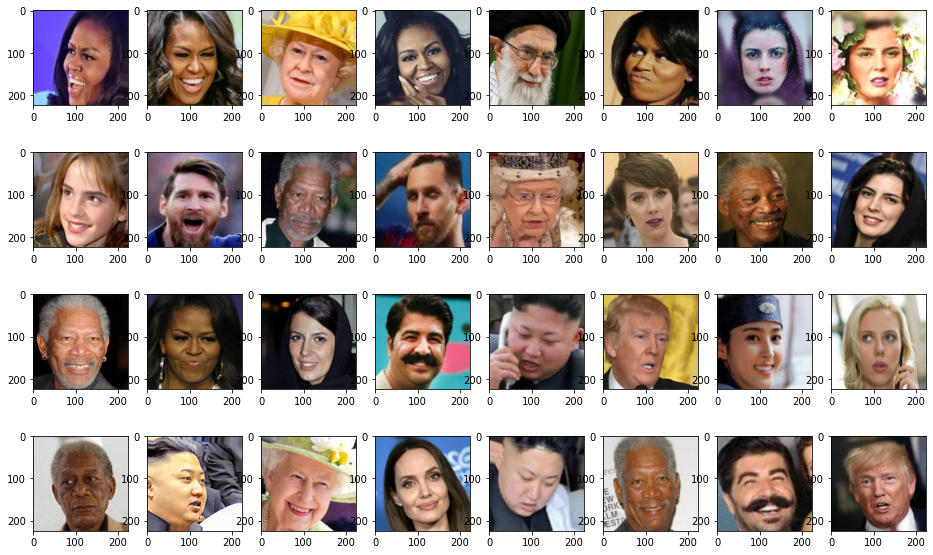

In [10]:
some_images=next(train_data)

X=some_images[0]
Y=some_images[1]

plt.figure(figsize=(16,10))
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(X[i])


In [11]:
class MyNet(Model):
  def __init__(self):
    super().__init__()

    self.pooling=MaxPooling2D()
    self.dense_1=Dense(128,activation='relu')
    self.dense_2=Dense(64,activation='relu')
    self.dense_3=Dense(14,activation='softmax')
    self.conv2d_1=Conv2D(32,(3,3),activation='relu',input_shape=(width,height,3))
    self.conv2d_2=Conv2D(64,(3,3),activation='relu')
    self.conv2d_3=Conv2D(128,(3,3),activation='relu')
    self.conv2d_4=Conv2D(256,(3,3),activation='relu')
    self.flatten=Flatten()
    self.droupout=Dropout(0.2)

  def call(self,x):
    layer1=self.conv2d_1(x)  
    layer2=self.pooling(layer1)

    layer3=self.conv2d_2(layer2)
    layer4=self.pooling(layer3)

    layer5=self.conv2d_3(layer4)
    layer6=self.pooling(layer5)

    layer7=self.conv2d_4(layer6)
    layer8=self.pooling(layer7)

    layer9=self.flatten(layer8)
    layer10=self.droupout(layer9)

    layer11=self.dense_1(layer10)
    layer12=self.droupout(layer11)

    layer13=self.dense_2(layer12)
    layer14=self.droupout(layer13)

    output=self.dense_3(layer14)
    return output




In [12]:
model=MyNet()


In [13]:
optimizer=tf.keras.optimizers.RMSprop(learning_rate=config.learning_rate)
loss_function=tf.keras.losses.CategoricalCrossentropy()


In [14]:
train_loss=tf.keras.metrics.MeanSquaredError()
val_loss=tf.keras.metrics.MeanSquaredError()
train_accuracy=tf.keras.metrics.CategoricalAccuracy()
val_accuracy=tf.keras.metrics.CategoricalAccuracy()

In [15]:

for epoch in range(epochs):
  train_accuracy.reset_states()
  train_loss.reset_states()
  val_accuracy.reset_states()
  val_loss.reset_states()

  print("Epoch:",epoch+1)

  #Training
  for _ in tqdm(range(train_data.samples//batch_size)):
    images, labels = next(train_data)
    with tf.GradientTape() as gTape:
      predictions=model(images,training=True)
      loss=loss_function(labels,predictions)
      train_loss(labels,predictions)

      train_accuracy(labels,predictions)
    gradients=gTape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
  
  
  #Validation
  for _ in tqdm(range(val_data.samples//batch_size)):
    images,labels=next(val_data)
    predictions=model(images,training=True)
    loss=loss_function(labels,predictions)
    val_accuracy(labels,predictions)
    val_loss(labels,predictions) 

  print("Train Accuracy: ",train_accuracy.result())  
  print("Train Loss: ",train_loss.result())   
  print("Val Accuracy: ",val_accuracy.result()) 
  print("Val Loss: ",val_loss.result())  


  wandb.log({'epochs':  epoch + 1,
                'Train_loss': np.mean(train_loss.result()),
                'Train_accuracy': float(train_accuracy.result()), 
                'val_loss': np.mean(val_loss.result()),
                'val_accuracy':float(val_accuracy.result())})



Epoch: 1


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.080340266, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.068270385, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.08203125, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.09480925, shape=(), dtype=float32)
Epoch: 2


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.11580882, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.06659648, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.20762712, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.06433012, shape=(), dtype=float32)
Epoch: 3


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.22778828, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.06293331, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.17372881, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.06414377, shape=(), dtype=float32)
Epoch: 4


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.2731569, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.059603803, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.33474576, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.055051204, shape=(), dtype=float32)
Epoch: 5


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.36862004, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.054761574, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.3644068, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.055191774, shape=(), dtype=float32)
Epoch: 6


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.44706994, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.049570937, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.41949153, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.050176676, shape=(), dtype=float32)
Epoch: 7


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.536862, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.043547448, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.4957627, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.048216853, shape=(), dtype=float32)
Epoch: 8


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.5869565, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.037965182, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.4957627, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.04509103, shape=(), dtype=float32)
Epoch: 9


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.6379962, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.03496211, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.5381356, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.044464137, shape=(), dtype=float32)
Epoch: 10


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.65500945, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.033088632, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.625, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.03635327, shape=(), dtype=float32)
Epoch: 11


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.7088847, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.028135587, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.62288135, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.03453869, shape=(), dtype=float32)
Epoch: 12


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.74196595, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.025596667, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.6398305, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.03664496, shape=(), dtype=float32)
Epoch: 13


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.7466919, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.024657043, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.58898306, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.037769187, shape=(), dtype=float32)
Epoch: 14


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.7646503, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.022727128, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.7372881, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.027362937, shape=(), dtype=float32)
Epoch: 15


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.7835539, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.021885956, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.6991525, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.030091096, shape=(), dtype=float32)
Epoch: 16


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.7835539, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.021941481, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.6737288, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.03269435, shape=(), dtype=float32)
Epoch: 17


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.8289225, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.017689208, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.7711864, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.02307787, shape=(), dtype=float32)
Epoch: 18


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.852552, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.015442605, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.7415254, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.025911318, shape=(), dtype=float32)
Epoch: 19


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.83648396, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.017252613, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.77734375, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.022480713, shape=(), dtype=float32)
Epoch: 20


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.8431002, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.016258085, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.6991525, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.030257042, shape=(), dtype=float32)
Epoch: 21


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.8846881, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.011736043, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.7457627, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.026497418, shape=(), dtype=float32)
Epoch: 22


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.8667297, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.014012872, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.7754237, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.023175014, shape=(), dtype=float32)
Epoch: 23


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.8827977, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.012970783, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.8220339, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.017916493, shape=(), dtype=float32)
Epoch: 24


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.879017, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.012375726, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.75, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.025638737, shape=(), dtype=float32)
Epoch: 25


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.8856333, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.0111696385, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.75, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.026828164, shape=(), dtype=float32)
Epoch: 26


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.89981097, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.011178396, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.7245763, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.028997201, shape=(), dtype=float32)
Epoch: 27


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.8913044, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.011093321, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.7542373, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.026313996, shape=(), dtype=float32)
Epoch: 28


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.9243856, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.008310323, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.7734375, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.024800844, shape=(), dtype=float32)
Epoch: 29


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.90831757, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.009802939, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.7881356, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.022753162, shape=(), dtype=float32)
Epoch: 30


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Accuracy:  tf.Tensor(0.915879, shape=(), dtype=float32)
Train Loss:  tf.Tensor(0.008806351, shape=(), dtype=float32)
Val Accuracy:  tf.Tensor(0.8177966, shape=(), dtype=float32)
Val Loss:  tf.Tensor(0.019558731, shape=(), dtype=float32)


In [16]:


model.save_weights(filepath='face_recognition',save_format='HDF5')

